In [95]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm ## If this line gives you an error, uncomment and execute the following cell

Populating the interactive namespace from numpy and matplotlib


In [96]:
path_to_data = 'https://raw.githubusercontent.com/ccontrer/MATH509-Winter2025-JupyterNotebooks/main/Data/'
data_all = pd.read_csv(path_to_data + "Howell1.csv", sep=";", header=0)

# Q1
Please use the code from the Week 3 notebook and modify it as necessary to answer this question.

Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.


# A
Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the **entire** Howell1 data frame, all 544 rows, adults and non-adults.

\begin{align*}
    h_{i} &\sim \text{Normal}(\mu_{i}, \sigma) \\
    \mu_{i} &= \alpha + e^{\log{\beta}} \log(w_i) \\
    \alpha & \sim \\
    \log(\beta) & \sim \\
    \sigma &\sim
\end{align*}

# B
To check the prior, plot 100 sample curves from prior predictive simulations (see Week 4 notebook for examples). Is the prior reasonable? Do you think it should be changed? Why or why not?

# C
Approximate the posterior distribution using the MCMC approximation (using Pymc3).

# D
Create a plot with the following information (each is a function of weight)
  1. a scatter plot of the data (height vs weight)
  2. predicted mean height
  3. the 97% interval for the mean height (use `fillbetween`)
  4. the 97% interval for posterior predicted heights (use `fillbetween`)
  
Be sure to label the $x$ and $y$ axis. Make it look nice.

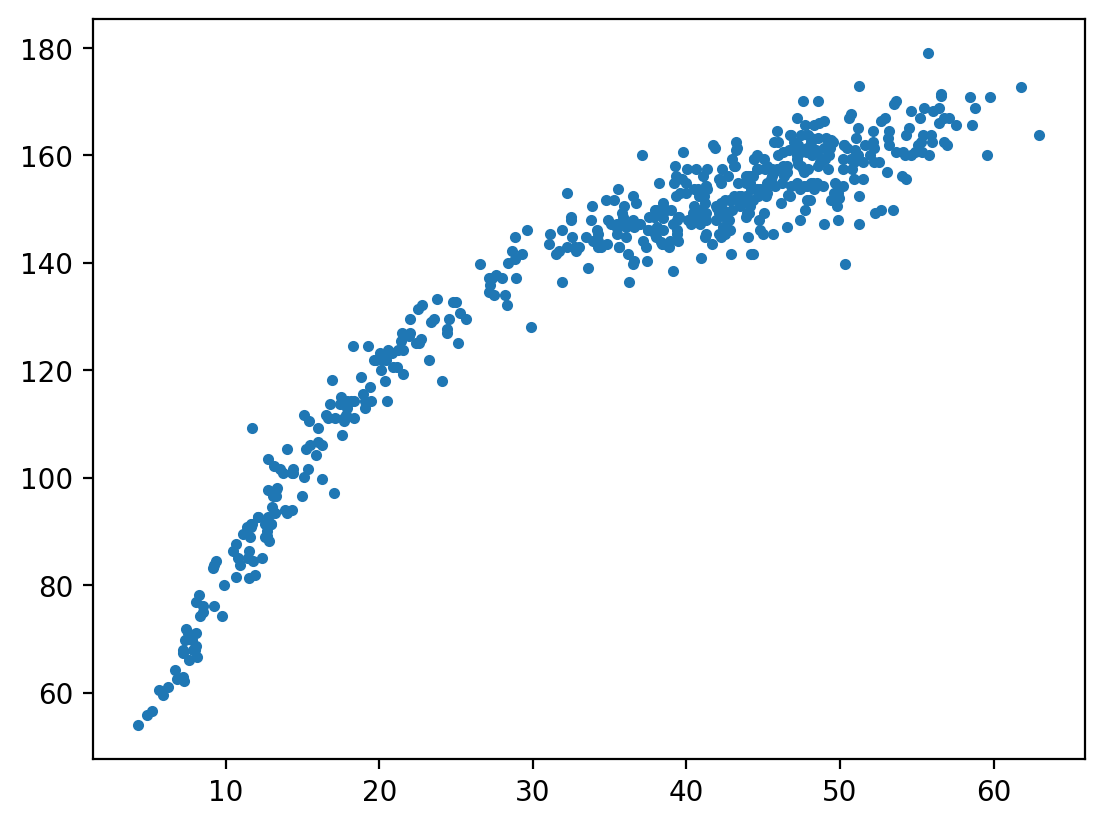

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm # or "import pymc3 as pm" if you are using PyMC3
import scipy.stats as stats
# Read the full Howell1 data (all 544 rows)
path_to_data = 'https://raw.githubusercontent.com/ccontrer/MATH509-Winter2025-JupyterNotebooks/main/Data/'
data_all = pd.read_csv(path_to_data + "Howell1.csv", sep=";", header=0)
plot(data_all['weight'],data_all['height'], '.' )

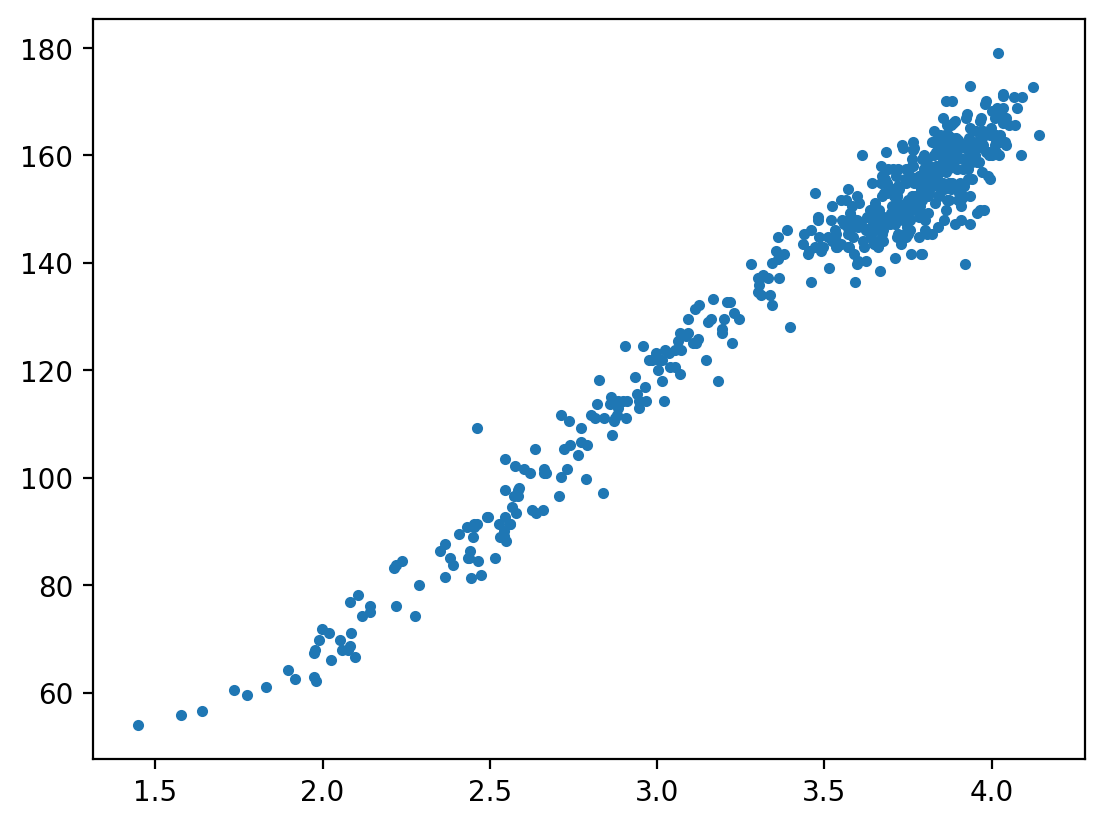

In [98]:
plot(np.log(data_all['weight']),data_all['height'], '.' )

In [100]:
data_all['log_weight'] = np.log(data_all['weight'])
with pm.Model() as model_logweight:
  alpha = pm.Normal('alpha', mu=178, sigma=29)
  logbeta = pm.Normal('logbeta', mu=0, sigma=1)
  sigma = pm.Uniform('sigma', lower=0, upper=45)
  mu = alpha + pm.math.exp(logbeta) * data_all['log_weight']
  height_obs = pm.Normal('height_obs', mu=mu, sigma=sigma, observed=data_all['height'])

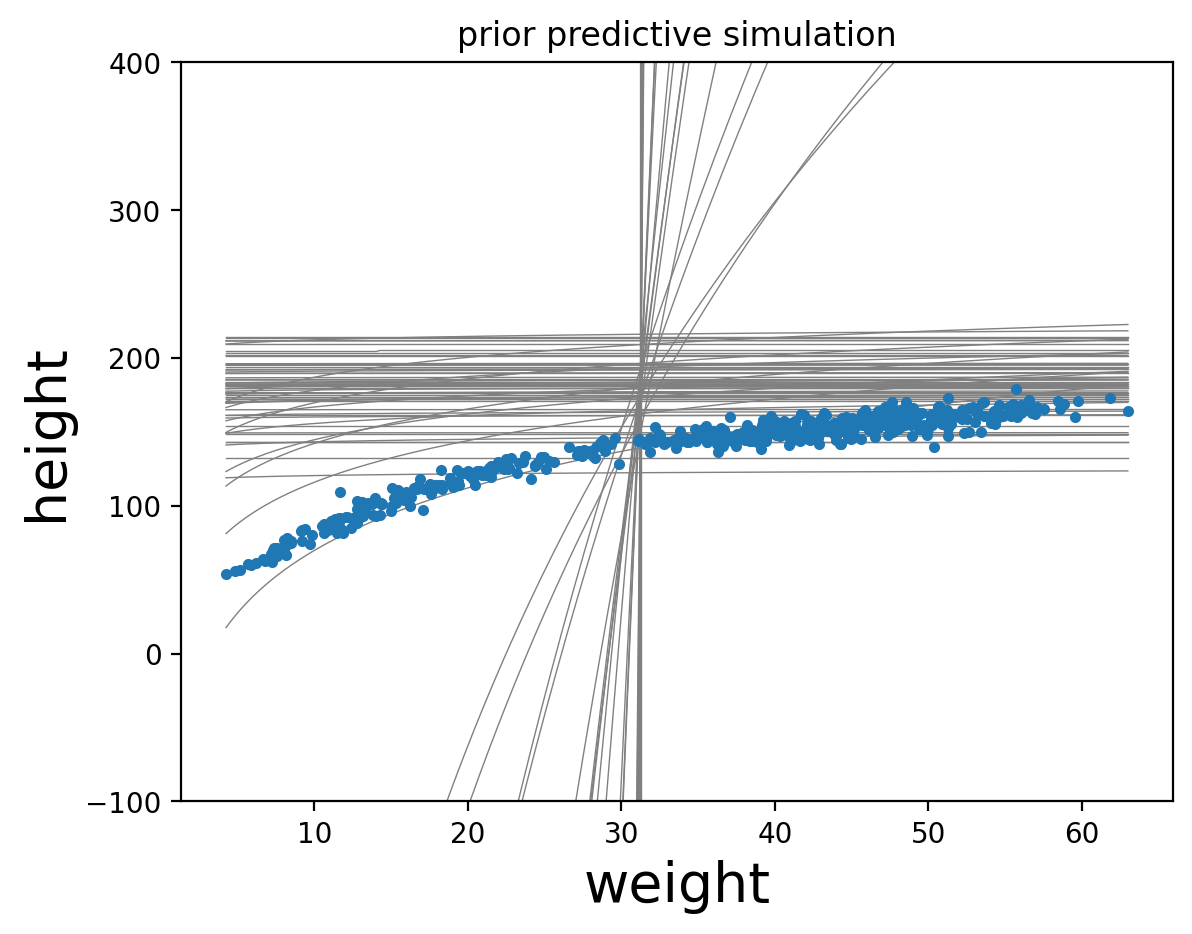

In [102]:
n_samples = 100 # 100 lines
alpha = stats.norm.rvs(178, 20, n_samples)
beta = stats.norm.rvs(0, 10, n_samples)

xmin = data_all['log_weight'].min()
xmax = data_all['log_weight'].max()
xmean = data_all['log_weight'].mean()
x = linspace(xmin, xmax, 200) ## weight range
## we are using broadcasting here (see Notebook in Week 3)
h_avg = alpha[None, :] + e**beta[None, :]*(x[:, None] - xmean)
plot(exp(x), h_avg, '0.5', lw=0.5)
ylim(-100, 400)
title('prior predictive simulation')
xlabel('weight', fontsize=20)
ylabel('height', fontsize=20)
plot(data_all['weight'],data_all['height'], '.' )

The plot shows a prior predictive simulation for height vs. log(weight), with gray lines representing prior samples and blue dots as actual
data. Some predictions are too extreme, suggesting that the priors for α and β might be too wide. Reducing their variance and using a
narrower uniform prior for σ could improve the model's predictive performance

Text(0, 0.5, 'height')

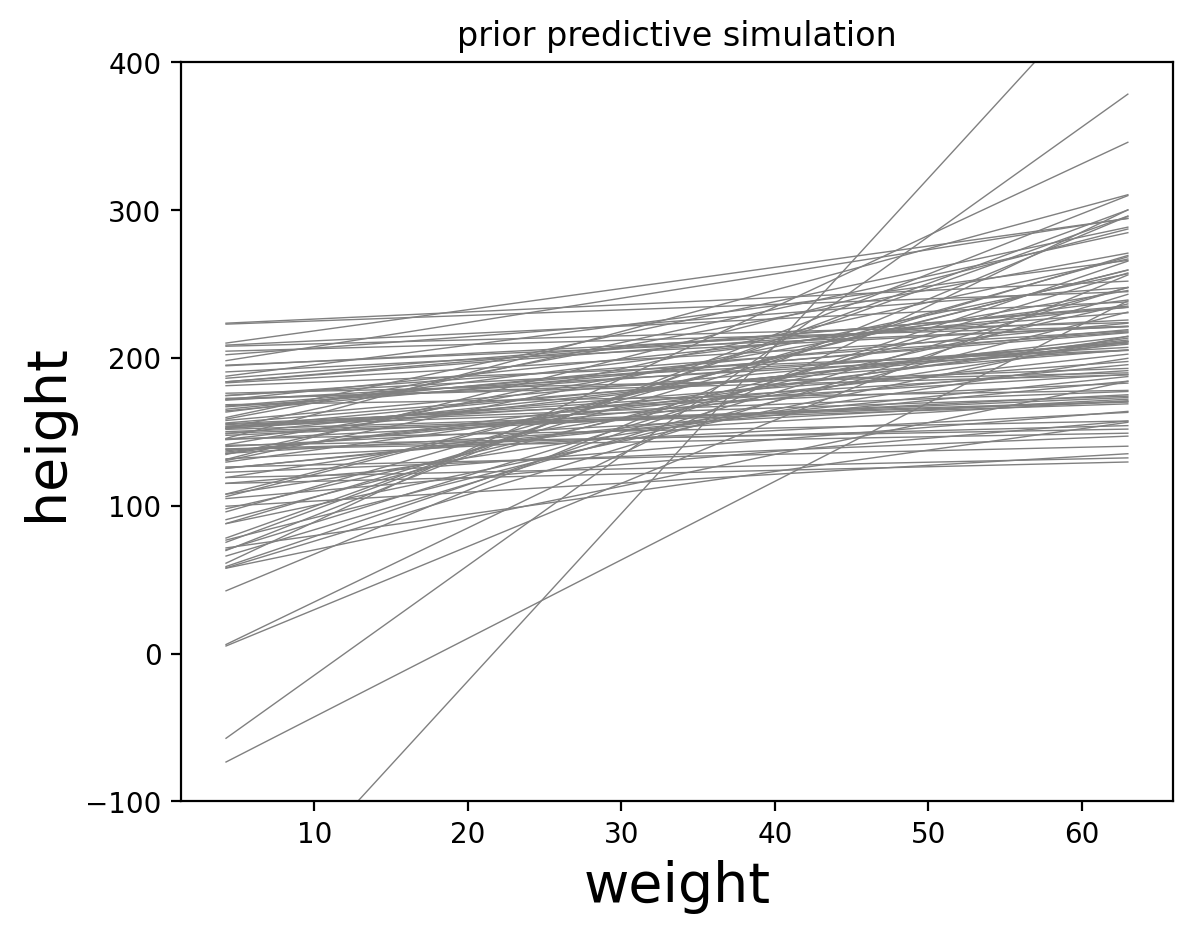

In [103]:
n_samples = 100 # 100 lines
alpha = stats.norm.rvs(178, 29, n_samples)
logbeta = stats.norm.rvs(0, 1, n_samples)
xmin = data_all['weight'].min()
xmax = data_all['weight'].max()
xmean = data_all['weight'].mean()
x = linspace(xmin, xmax, 5) ## weight range
h_avg = alpha[None, :] + exp(logbeta[None, :])*(x[:, None] - xmean) ## we are using broadcasting here
plot(x, h_avg, '0.5', lw=0.5)
ylim(-100, 400)
title('prior predictive simulation')
xlabel('weight', fontsize=20)
ylabel('height', fontsize=20)

In [113]:
## C
with pm.Model() as model:
  alpha = pm.Normal('alpha', mu=178, sigma=29)
  beta = pm.Normal('beta', mu=0, sigma=17)
  sigma = pm.Uniform('sigma', lower=0, upper=45)
  mu = alpha + beta * (data_all['weight'] - data_all['weight'].mean())
  height = pm.Normal('height', mu=mu, sigma=sigma, observed=data_all['height'])
  trace = pm.sample(3000, tune=1000)

Output()

Output()

In [114]:
summary = pm.summary(trace)
print(summary)

          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha  138.274  0.407  137.470  138.997      0.004    0.003    9320.0   
beta     1.765  0.027    1.714    1.815      0.000    0.000    9780.0   
sigma    9.387  0.286    8.876    9.919      0.003    0.002    9102.0   

       ess_tail  r_hat  
alpha    4343.0    1.0  
beta     4504.0    1.0  
sigma    4710.0    1.0  


In [115]:
trace_df = trace.posterior.to_dataframe()
trace_df

alpha      beta     sigma
chain draw                                
0     0     138.289463  1.773036  9.318008
      1     138.013983  1.713142  9.497871
      2     138.247026  1.714166  9.605099
      3     138.178322  1.793429  9.175565
      4     138.216053  1.746047  9.619960
...                ...       ...       ...
1     2995  138.622439  1.769985  9.383962
      2996  137.909072  1.756679  9.638703
      2997  137.909072  1.756679  9.638703
      2998  138.627136  1.770598  9.436006
      2999  137.867596  1.739177  9.079976

[6000 rows x 3 columns]

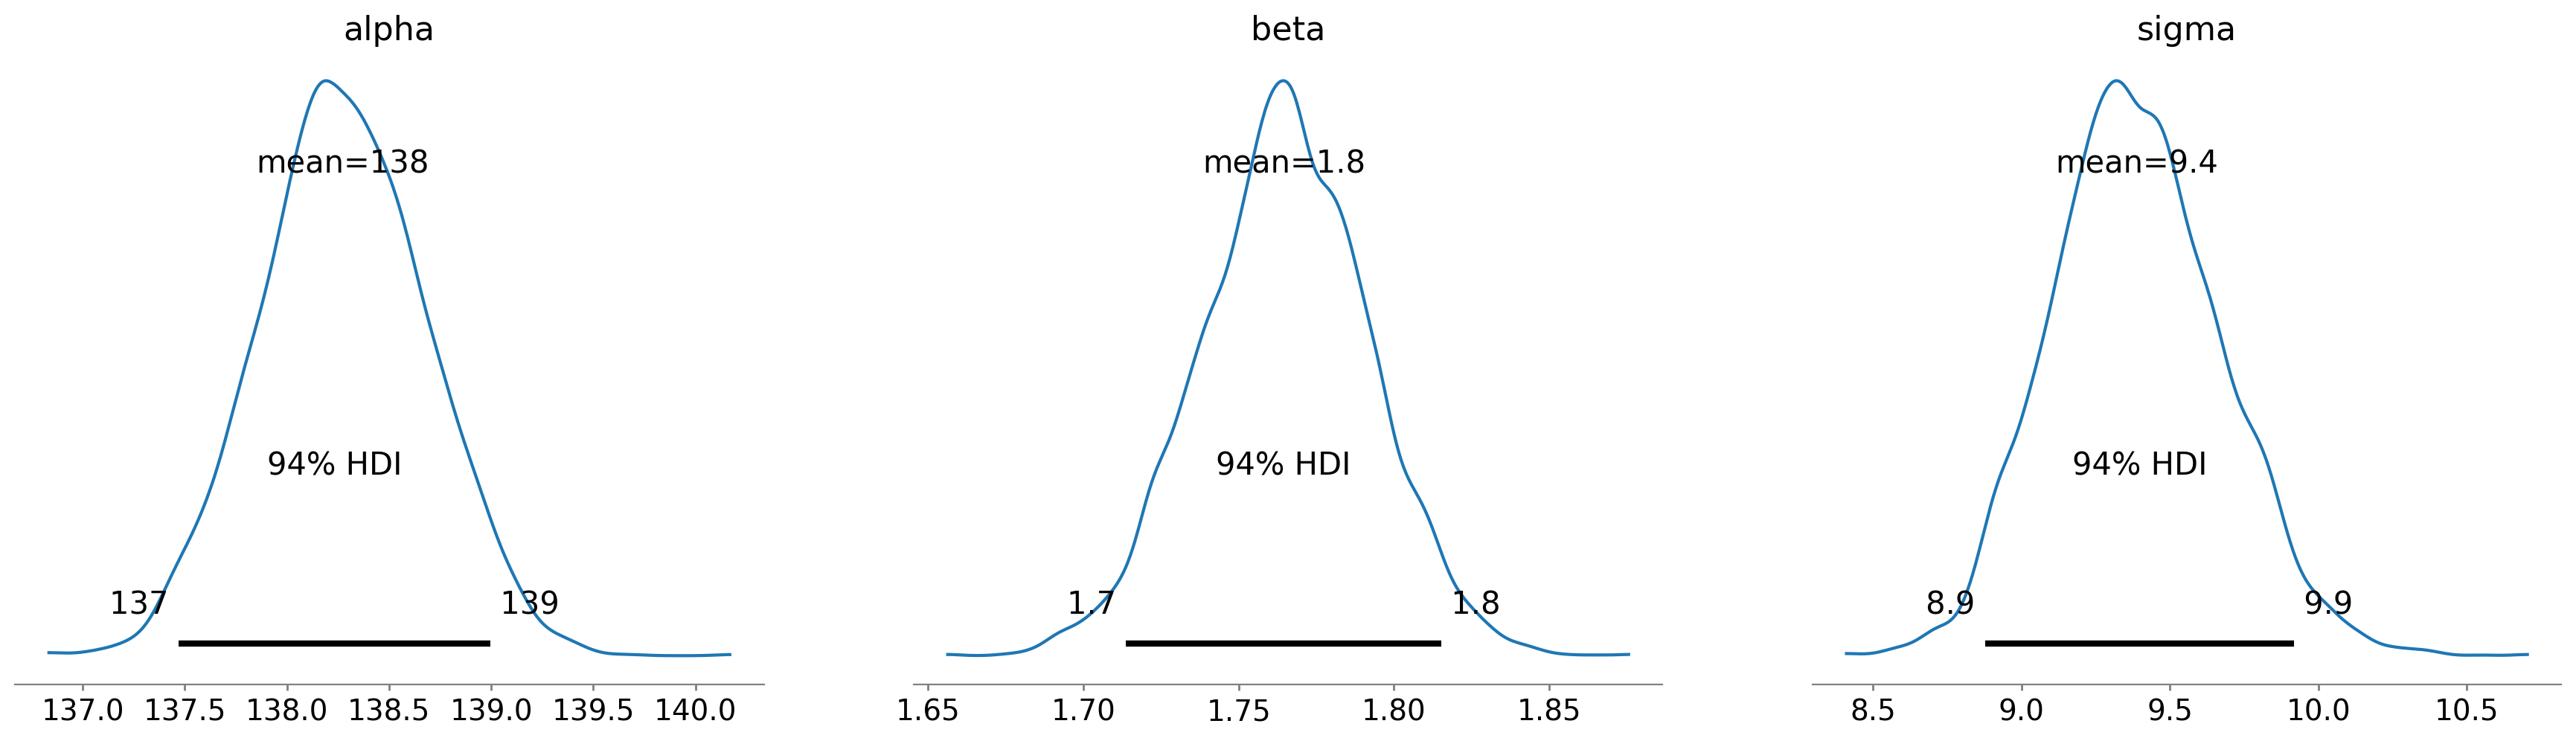

In [116]:
pm.plot_posterior(trace, var_names=["alpha", "beta", "sigma"])
plt.show()

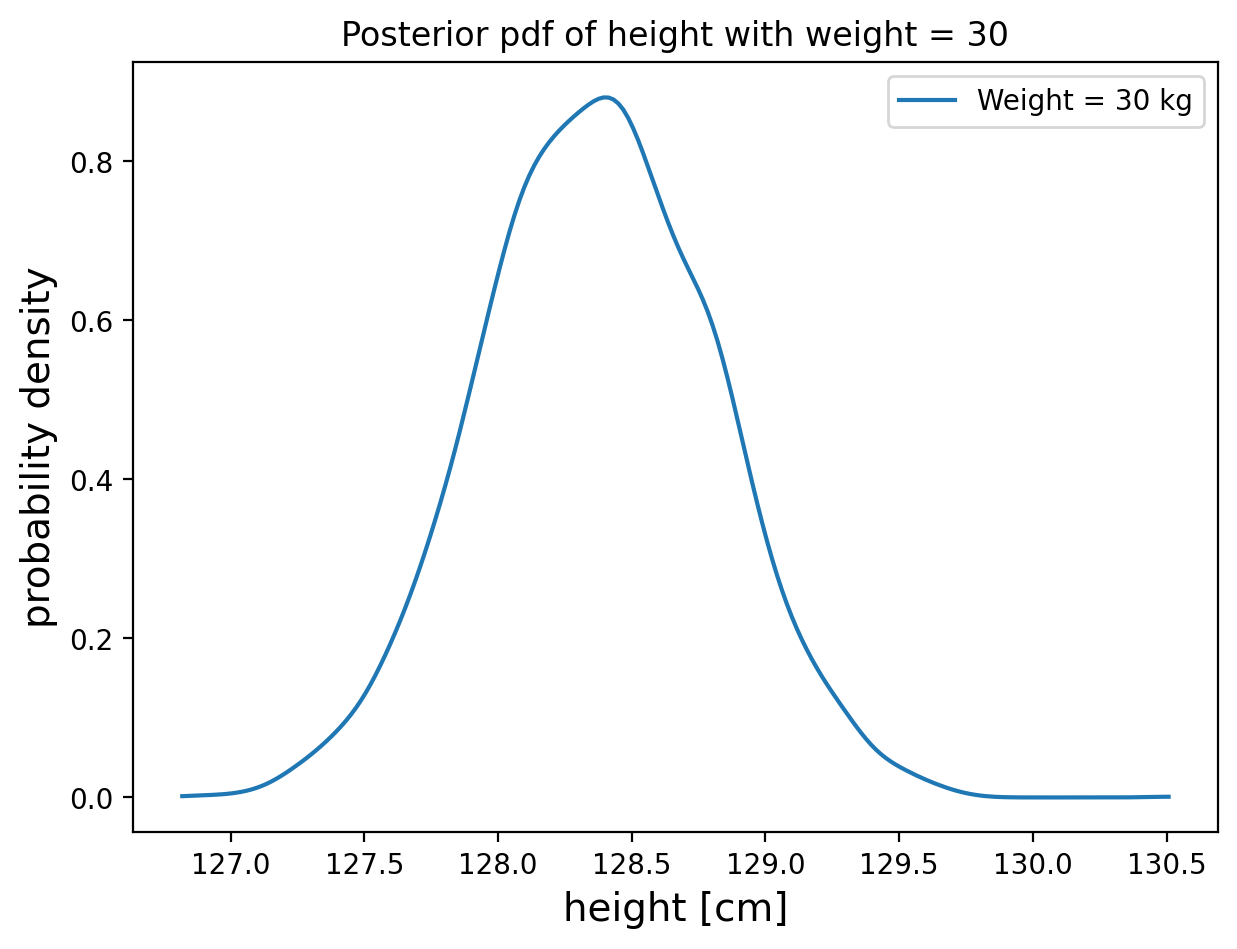

In [117]:
alpha_samples = np.array(trace_df['alpha'])
beta_samples = np.array(trace_df['beta'])
weight_target = 30
h_avg_samples = alpha_samples + beta_samples * (weight_target - data_all['weight'].mean())
kde_posterior_pdf = stats.gaussian_kde(h_avg_samples)
plt.figure(figsize=(7, 5))
x_to_plot = np.linspace(h_avg_samples.min(), h_avg_samples.max(), 200)
plt.plot(x_to_plot, kde_posterior_pdf(x_to_plot), label=f'Weight = {weight_target} kg')
plt.title(f'Posterior pdf of height with weight = {weight_target}')
plt.xlabel('height [cm]', fontsize=14)
plt.ylabel('probability density', fontsize=14)
plt.legend()
plt.show()

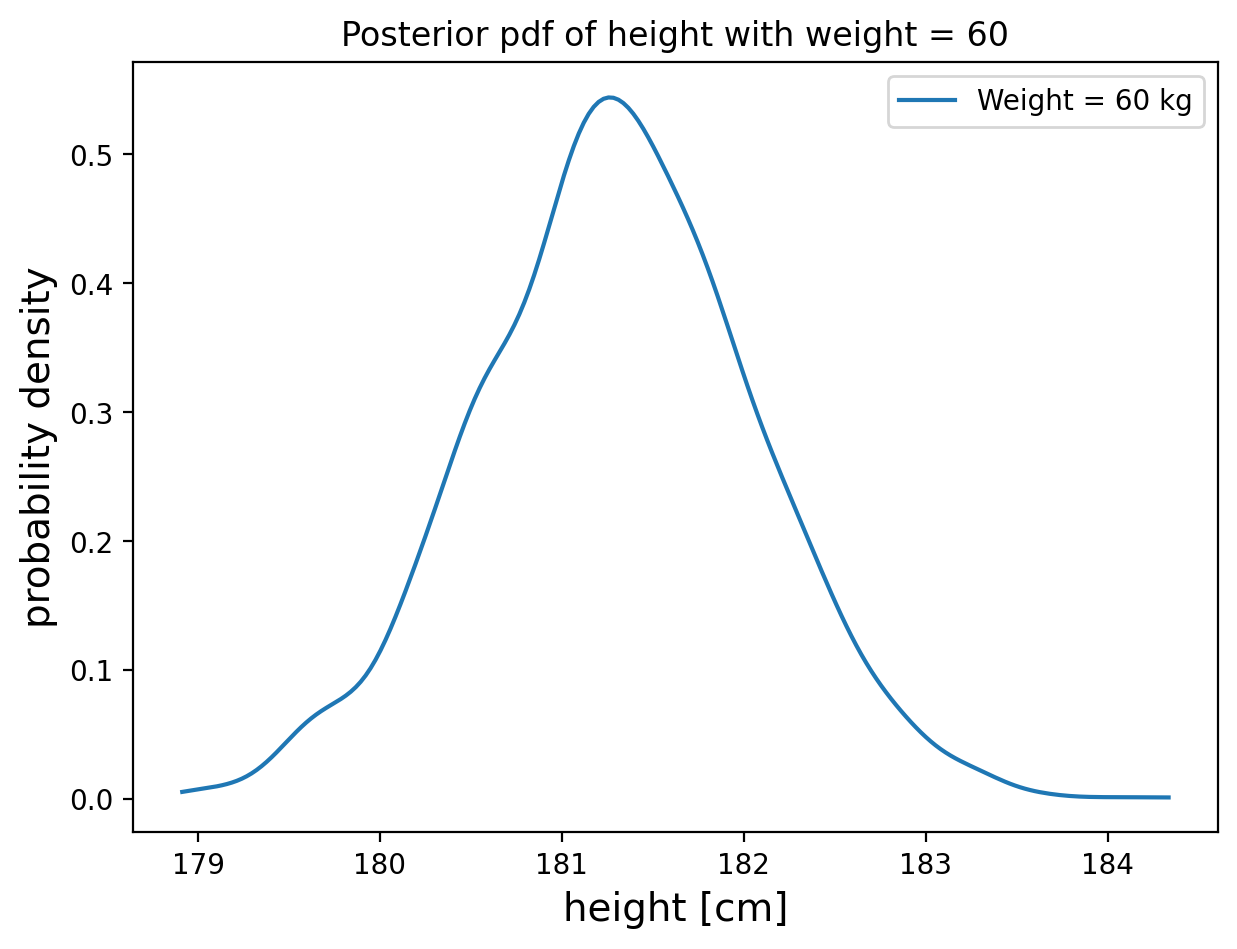

In [110]:
alpha_samples = np.array(trace_df['alpha'])
beta_samples = np.array(trace_df['beta'])
weight_target = 60
h_avg_samples = alpha_samples + beta_samples * (weight_target - data_all['weight'].mean())
kde_posterior_pdf = stats.gaussian_kde(h_avg_samples)
plt.figure(figsize=(7, 5))
x_to_plot = np.linspace(h_avg_samples.min(), h_avg_samples.max(), 200)
plt.plot(x_to_plot, kde_posterior_pdf(x_to_plot), label=f'Weight = {weight_target} kg')
plt.title(f'Posterior pdf of height with weight = {weight_target}')
plt.xlabel('height [cm]', fontsize=14)
plt.ylabel('probability density', fontsize=14)
plt.legend()
plt.show()

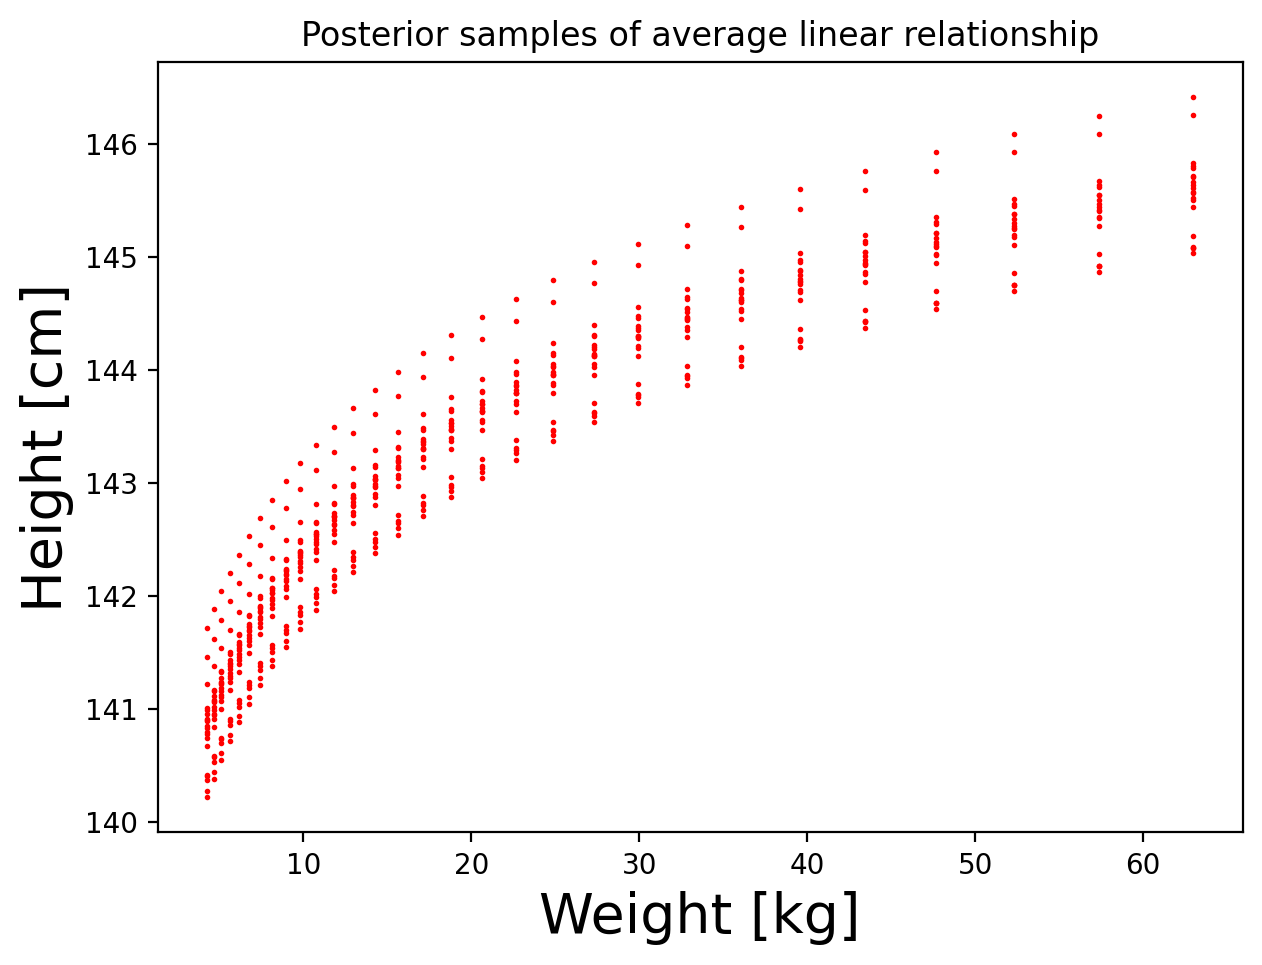

In [111]:
dw = data_all['log_weight']
xmin = dw.min()
xmax = dw.max()
xmean = dw.mean()
x = np.linspace(xmin, xmax, 30)
alpha_samples = np.array(trace_df['alpha'])[None, ::100]
beta_samples = np.array(trace_df['beta'])[None, ::100]
mu_samples = alpha_samples + beta_samples * x[:, None]
plt.figure(figsize=(7, 5))
plt.plot(np.exp(x), mu_samples, 'r.', ms=2)
plt.title('Posterior samples of average linear relationship')
plt.xlabel('Weight [kg]', fontsize=20)
plt.ylabel('Height [cm]', fontsize=20)
plt.show()

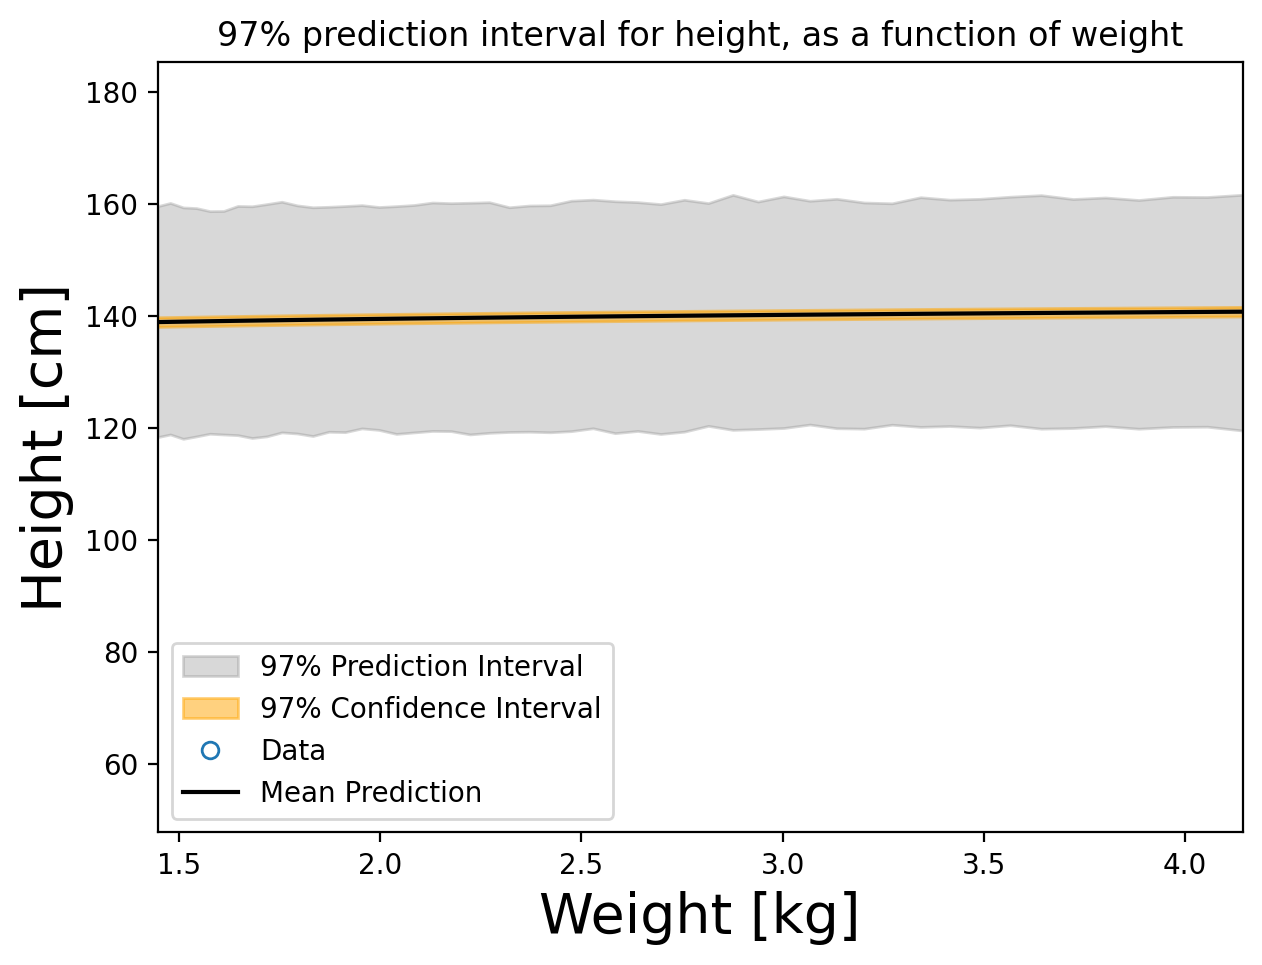

In [118]:
prob = 0.97
xmin = np.log(dw.min())
xmax = np.log(dw.max())
xmean = np.log(dw.mean())
N_weight = 50
x = np.linspace(xmin, xmax, N_weight)
if 'logbeta' in trace_df.columns:
  logbeta_samples = np.array(trace_df['logbeta'])[None, :]
else:
  logbeta_samples = np.log(np.array(trace_df['beta']))[None, :]
alpha_samples = np.array(trace_df['alpha'])[None, :]
sigma_samples = np.array(trace_df['sigma'])[None, :]
N_posterior_samples = alpha_samples.size
mu_avg = alpha_samples.mean() + np.exp(logbeta_samples).mean() * x
mu_samples = alpha_samples + np.exp(logbeta_samples) * x[:, None]
mu_samples_sorted = np.sort(mu_samples, axis=1)
index = int(N_posterior_samples * (1 - prob) / 2)
mu_lower = mu_samples_sorted[:, index]
mu_upper = mu_samples_sorted[:, -index]
h_samples = stats.norm.rvs(mu_samples, sigma_samples, size=(N_weight, N_posterior_samples))
h_samples_sorted = np.sort(h_samples, axis=1)

index = int(N_posterior_samples * (1 - prob) / 2)
h_lower = h_samples_sorted[:, index]
h_upper = h_samples_sorted[:, -index]
plt.figure(figsize=(7, 5))
plt.fill_between(np.exp(x), h_upper, h_lower, color='0.5', alpha=0.3, label="97% Prediction Interval")
plt.fill_between(np.exp(x), mu_upper, mu_lower, color='orange', alpha=0.5, label="97% Confidence Interval")
plt.plot(np.exp(dw), data_all['height'], 'o', mfc='none', label="Data")
plt.plot(np.exp(x), mu_avg, 'k', label="Mean Prediction")
plt.xlim(np.exp(xmin), np.exp(xmax))
plt.title('97% prediction interval for height, as a function of weight')
plt.xlabel('Weight [kg]', fontsize=20)
plt.ylabel('Height [cm]', fontsize=20)
plt.legend()
plt.show()